# Using python to mimic FORTRAN CJ code

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time, multiprocessing, os, sys
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from matplotlib.ticker import LogLocator
from functools import lru_cache
from joblib import Parallel, delayed


# Reading the input file

In [2]:
filepath = '/Users/AbSir/Desktop/cj22/CJ-code/fitpack/nucl/phi.wbarel_AV18'
gamma_list = []
y_list = []
f2_list = []
f0_list = []
with open(filepath, 'r') as file:
    for line in file:
        try:
            columns = [float(col) for col in line.split()]
            if len(columns) == 8:
                gamma_list.append(columns[0])
                y_list.append(columns[1])
                f2_list.append(columns[6])
                f0_list.append(columns[2])
        except:
            continue
gamma_array = np.array(gamma_list)
y_array = np.array(y_list)
f2_array = np.array(f2_list)
f0_array = np.array(f0_list)

# The faster integration

In [26]:
results_cache = {}  # Dictionary to cache (avoid multiple computation)

def get_interpolator(gamma_fixed):
    # Check if the interpolator is already computed
    if gamma_fixed not in results_cache:
        mask = gamma_array == gamma_fixed
        y_filtered = y_array[mask]
        f0_filtered = f0_array[mask]
        results_cache[gamma_fixed] = interp1d(y_filtered, f0_filtered, kind='linear', fill_value='extrapolate')
    return results_cache[gamma_fixed]

def phi_int2d_fixed_gamma(y_D, gamma_fixed):
    interpolator = get_interpolator(gamma_fixed)
    return interpolator(y_D)

def f2nxn_function(x):
    x_N = 2 * x # Convert from x_D to x_N
    return 4 * x_N**0.7 * (1 - x_N)**3.5 * (1 + 4 * x_N) + 0.15 * x_N**(-0.4) * (1 - x_N)**9 * (1 + 16 * x_N)

def f2_function(x, y_D):
    k = x / y_D
    return 4 * k**0.7 * (1 - k)**3.5 * (1 + 4 * k) + 0.15 * k**(-0.4) * (1 - k)**9 * (1 + 16 * k)

def integrand(y_D, x):
    f0 = phi_int2d_fixed_gamma(y_D, gamma_fixed)
    f2 = f2_function(x, y_D)
    return f2 * f0

def integrate_f2_f0(x_val):
    f2dxd, error = quad(integrand, x_val, 1, args=(x_val,))
    return f2dxd, error

gamma_fixed = 1.0
x = np.linspace(0, 1, 5000)  # x_D values

# Parallel computation. n_jobs=-1 means using all available cores. The delayed function is a way to specify a computation without actually running it. This allows the Parallel object to run the computation in parallel.
results = Parallel(n_jobs=-1)(delayed(integrate_f2_f0)(x_val) for x_val in x)
integral_result_list, error_list = zip(*results)
print(f"Number of cores available: {multiprocessing.cpu_count()}")
simple_f2_list = [f2nxn_function(x_val) for x_val in x]
ratio = np.array(integral_result_list) / np.array(simple_f2_list)
print("Length of error list: ", len(error_list))

/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_5447/569069198.py:22: RuntimeWarning: divide by zero encountered in scalar power
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_5447/569069198.py:27: RuntimeWarning: invalid value encountered in multiply
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_5447/569069198.py:30: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_5447/569069198.py:30: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subra

Number of cores available: 8
Length of error list:  5000


/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_5447/569069198.py:18: RuntimeWarning: divide by zero encountered in scalar power
  return 4 * x_N**0.7 * (1 - x_N)**3.5 * (1 + 4 * x_N) + 0.15 * x_N**(-0.4) * (1 - x_N)**9 * (1 + 16 * x_N)
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_5447/569069198.py:18: RuntimeWarning: invalid value encountered in scalar power
  return 4 * x_N**0.7 * (1 - x_N)**3.5 * (1 + 4 * x_N) + 0.15 * x_N**(-0.4) * (1 - x_N)**9 * (1 + 16 * x_N)


# Plot it

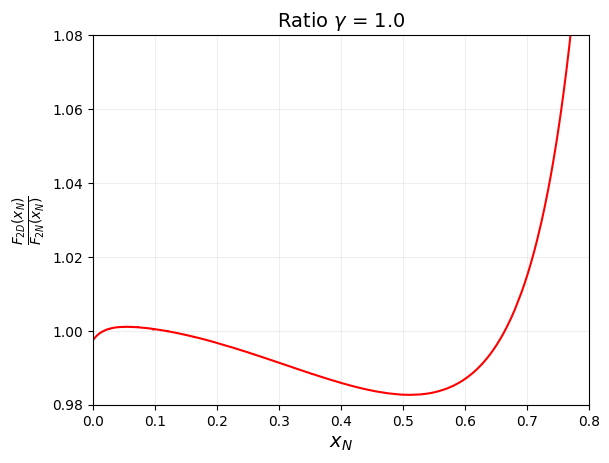

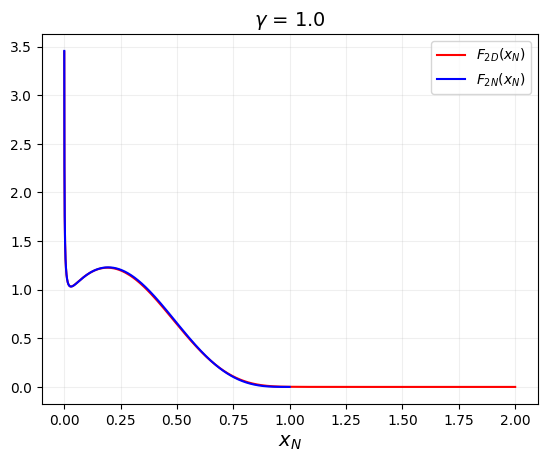

In [23]:
fig3, ax3 = plt.subplots()
x_N = x * 2
ax3.plot(x_N, ratio, 'r')
ax3.grid(alpha = 0.2)
ax3.set_xlabel(r'$x_N$', fontsize = 14)
ax3.set_ylabel(r'$\frac{F_{2D}(x_N)}{F_{2N}(x_N)}$', fontsize = 14)
ax3.set_title(fr'Ratio $\gamma$ = {gamma_fixed}', fontsize = 14)
ax3.set_xlim(0.0, 0.8)
ax3.set_ylim(0.98, 1.08)
# ax3.set_yscale('log')
fig3.savefig(f'plots/ratio_{time.time():.0f}.pdf')

fig2, ax2 = plt.subplots()
# ax2.plot(x, integral_result_list, 'r', label = r'$\int_{x_D}^1 dy_D f_0(y_D;\gamma)F_{2N}(x_D/y_D)$')
ax2.plot(x_N, integral_result_list, 'r', label = r'$F_{2D}(x_N)$')
ax2.plot(x_N, simple_f2_list, 'b', label = r'$F_{2N}(x_N)$')
ax2.grid(alpha = 0.2)
ax2.set_xlabel(r'$x_N$', fontsize = 14)
ax2.set_title(fr'$\gamma$ = {gamma_fixed}', fontsize = 14)
ax2.legend()
fig2.savefig(f'plots/integral_{time.time():.0f}.pdf')

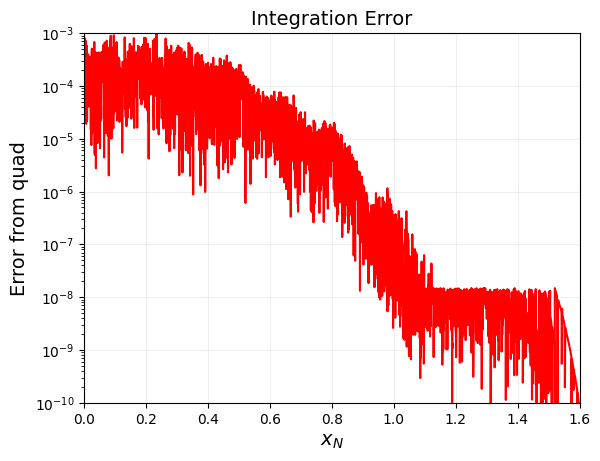

In [25]:
fig, ax = plt.subplots()
x_N = 2 * x
ax.plot(x_N, error_list, 'r')
ax.grid(alpha = 0.2)
ax.set_xlabel(r'$x_N$', fontsize = 14)
ax.set_ylabel('Error from quad', fontsize = 14)
ax.set_title('Integration Error', fontsize = 14)
ax.set_yscale('log')
ax.set_xlim(0, 1.6)
ax.set_ylim(1e-10, 1e-3)
plt.savefig(f'plots/error_{time.time():.0f}.pdf')